In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import spacy
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import spacy
import glob
import os
import re
import string
from bs4 import BeautifulSoup
import nltk

d:\jupyter\big data\project\spark-test\venv_tf_1\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\reddy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
nlp = spacy.load("en_core_web_lg-3.4.1/en_core_web_lg/en_core_web_lg-3.4.1")

In [4]:
sof_false_df = pd.read_json('D:/jupyter/big data/project/model/processed_data/is-duplicate-false/is_dup_false.json', lines=True)

In [7]:
def read(x):
    return pd.read_json(x, lines=True)

In [ ]:
joined_files = os.path.join("D:\\jupyter\\big data\\project\\model\\processed_data\\combined_data", "*.json")
joined_list = glob.glob(joined_files)
sof_df = pd.concat(map(read, joined_list), ignore_index=True)


In [ ]:
sof_dup_df = sof_df[sof_df["is_duplicate"]==True].iloc[0:50000]
sof_non_dup_df = sof_df[sof_df["is_duplicate"]==False].iloc[0:50000]
sof_concat_df = pd.concat((sof_dup_df,sof_non_dup_df),axis=0)
sof_concat_df = sof_concat_df.sample(frac = 1)
sof_concat_df.reset_index(inplace=True, drop=True)
sof_concat_df["is_duplicate"] = sof_concat_df["is_duplicate"].astype(int)


# Data Cleaning

In [10]:
def preprocess(question):
    question = question.lower()
    stop_words = nltk.corpus.stopwords.words("english")
    for w in ["what", "when", "where", "who", "whom", "which","whose","why","how"]:
        if w in stop_words:
            stop_words.remove(w)
    question = re.sub(r'\n', '', question)
    remove_punct = str.maketrans('', '', string.punctuation)
    question = question.translate(remove_punct)
    question = question.split()
    question = [word for word in question if not word in stop_words]
    question = nlp(' '.join(question))
    
    lemma_words = [y.lemma_ for y in question]
    return lemma_words

In [11]:
sof_concat_df["question1_cleaned"] = sof_concat_df['question1'].apply(lambda x: preprocess(x))
sof_concat_df["question2_cleaned"] = sof_concat_df['question2'].apply(lambda x: preprocess(x))

In [12]:
sof_concat_df = sof_concat_df.drop(columns=['id1', 'row1','id2','row2'])

# Similarity metrics:

In [17]:
from scipy.spatial.distance import cosine,cityblock,euclidean,minkowski,jaccard


In [18]:
def cal_similarities(q1_embed,q2_embed):
    cos_sim = 1 - cosine(q1_embed,q2_embed)
    man_sim = 1 / (1 + cityblock(q1_embed,q2_embed))
    euc_sim = 1 / (1 + euclidean(q1_embed,q2_embed))
    return cos_sim,man_sim,euc_sim
    

#     SBERT

In [17]:
from sentence_transformers import SentenceTransformer

In [18]:
sbert_model = SentenceTransformer('distilbert-base-nli-mean-tokens')

In [19]:
def gen_sbert_embedding(text):
    vectors = sbert_model.encode(text)
    return vectors

In [20]:
sb_cos_sim_arr=[]
sb_man_sim_arr=[]
sb_euc_sim_arr=[]

for q1,q2,label in tqdm(zip(list(sof_concat_df["question1"]),list(sof_concat_df["question2"]),list(sof_concat_df["is_duplicate"]))):
    
    q1_embed = gen_sbert_embedding(q1.lower())
    q2_embed = gen_sbert_embedding(q2.lower())
    
    sb_cos_sim,sb_man_sim,sb_euc_sim = cal_similarities(q1_embed,q2_embed)
    
    sb_cos_sim_arr.append(sb_cos_sim)
    sb_man_sim_arr.append(sb_man_sim*10)
    sb_euc_sim_arr.append(sb_euc_sim*10)
    
sof_concat_df["sb_cos_sim"] = sb_cos_sim_arr
sof_concat_df["sb_man_sim"] = sb_man_sim_arr
sof_concat_df["sb_euc_sim"] = sb_euc_sim_arr


                

100000it [54:30, 30.57it/s]


In [21]:
sof_concat_df

,question1,question2,is_duplicate,question1_cleaned,question2_cleaned,sb_cos_sim,sb_man_sim,sb_euc_sim
0,standalone parentheses in javascript,A Javascript function,1,"[standalone, parenthesis, javascript]","[javascript, function]",0.848738,0.049302,0.974596
1,See if a Radio button is checked that isn't in...,How to get VALUE from FORM without Submitting it?,1,"[see, radio, button, check, be, not, inside, f...","[how, get, value, form, without, submit]",0.338827,0.024686,0.516216
2,Pagination and .htaccess,J2ME/Blackberry - how to read/write text file?,0,"[pagination, htaccess]","[j2meblackberry, how, readwrite, text, file]",0.371934,0.024778,0.518206
3,A Windows equivalent of the Unix tail command,How will you categorise the various software t...,0,"[window, equivalent, unix, tail, command]","[how, categorise, various, software, testing, ...",0.538113,0.028768,0.590299
4,Solr 4.1 Core Initialization Failure,Solr RequestHandler init failure,1,"[solr, 41, core, initialization, failure]","[solr, requesthandler, init, failure]",0.791258,0.042740,0.872217
...,...,...,...,...,...,...,...,...
99995,PHP Maths Equation Function,"SGEN, InternalsVisibleTo and assembly signing",0,"[php, maths, equation, function]","[sgen, internalsvisibleto, assembly, signing]",0.588093,0.030861,0.635260
99996,How can I check if all the elements of an Arra...,Java all determine elements are same in a list,1,"[how, check, element, arraylist, java]","[java, determine, element, list]",0.796350,0.043191,0.874272
99997,Is there a way to import a 3D model into Android?,General way to reset a member variable to its ...,0,"[way, import, 3d, model, android]","[general, way, reset, member, variable, origin...",0.366446,0.024452,0.515358
99998,How to remove a wpf element on a canvas by it'...,Sign in form and register form,0,"[how, remove, wpf, element, canvas, tag, name]","[sign, form, register, form]",0.478150,0.027039,0.567456


In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

d:\jupyter\big data\project\spark-test\venv_tf_1\lib\site-packages\ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.
d:\jupyter\big data\project\spark-test\venv_tf_1\lib\site-packages\ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



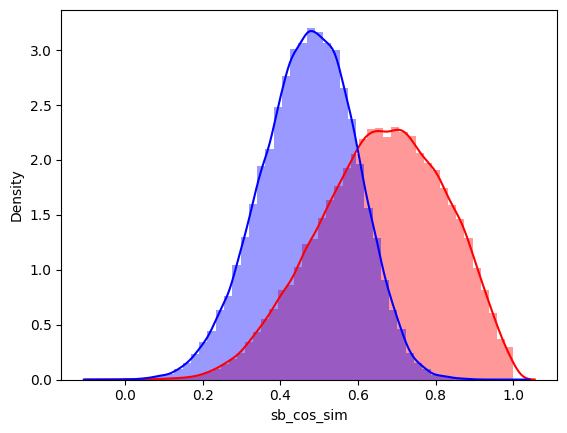

In [23]:
sns.distplot(sof_concat_df[sof_concat_df['is_duplicate'] == 1]['sb_cos_sim'][0:] , label = "1", color = 'red')
sns.distplot(sof_concat_df[sof_concat_df['is_duplicate'] == 0]['sb_cos_sim'][0:] , label = "0" , color = 'blue' )
plt.show()

d:\jupyter\big data\project\spark-test\venv_tf_1\lib\site-packages\ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.
d:\jupyter\big data\project\spark-test\venv_tf_1\lib\site-packages\ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



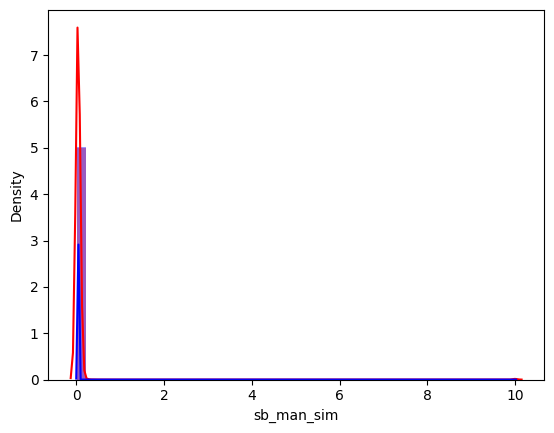

In [24]:
sns.distplot(sof_concat_df[sof_concat_df['is_duplicate'] == 1]['sb_man_sim'][0:] , label = "1", color = 'red')
sns.distplot(sof_concat_df[sof_concat_df['is_duplicate'] == 0]['sb_man_sim'][0:] , label = "0" , color = 'blue' )
plt.show()

d:\jupyter\big data\project\spark-test\venv_tf_1\lib\site-packages\ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.
d:\jupyter\big data\project\spark-test\venv_tf_1\lib\site-packages\ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



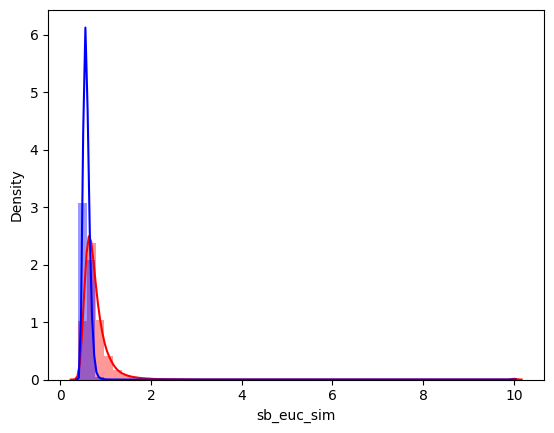

In [25]:
sns.distplot(sof_concat_df[sof_concat_df['is_duplicate'] == 1]['sb_euc_sim'][0:] , label = "1", color = 'red')
sns.distplot(sof_concat_df[sof_concat_df['is_duplicate'] == 0]['sb_euc_sim'][0:] , label = "0" , color = 'blue' )
plt.show()

# FastText

In [13]:
sof_concat_df['question1_cleaned'].apply(lambda x: ' '.join(x)).to_csv(r'questions.txt', sep="\n", mode='a', index=False, header=False)
sof_concat_df['question2_cleaned'].apply(lambda x: ' '.join(x)).to_csv(r'questions.txt', sep="\n", mode='a', index=False, header=False)

In [14]:
import fasttext

In [15]:
ft_model = fasttext.train_unsupervised('questions.txt', model='skipgram',dim=300,epoch=25)

In [19]:
ft_cos_sim_arr=[]
ft_man_sim_arr=[]
ft_euc_sim_arr=[]

for q1_tokens,q2_tokens in tqdm(zip(list(sof_concat_df["question1"]),list(sof_concat_df["question2"]))):

    q1 = ' '.join(q1_tokens)
    q2 = ' '.join(q2_tokens)
    q1_embed = ft_model.get_sentence_vector(q1)
    q2_embed = ft_model.get_sentence_vector(q2)
    
    ft_cos_sim,ft_man_sim,ft_euc_sim = cal_similarities(q1_embed,q2_embed)
    ft_cos_sim_arr.append(ft_cos_sim)
    ft_man_sim_arr.append(ft_man_sim)
    ft_euc_sim_arr.append(ft_euc_sim)

    
sof_concat_df["ft_cos_sim"] = ft_cos_sim_arr
sof_concat_df["ft_man_sim"] = ft_man_sim_arr
sof_concat_df["ft_euc_sim"] = ft_euc_sim_arr

100000it [00:26, 3833.55it/s]


d:\jupyter\big data\project\spark-test\venv_tf_1\lib\site-packages\ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.
d:\jupyter\big data\project\spark-test\venv_tf_1\lib\site-packages\ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



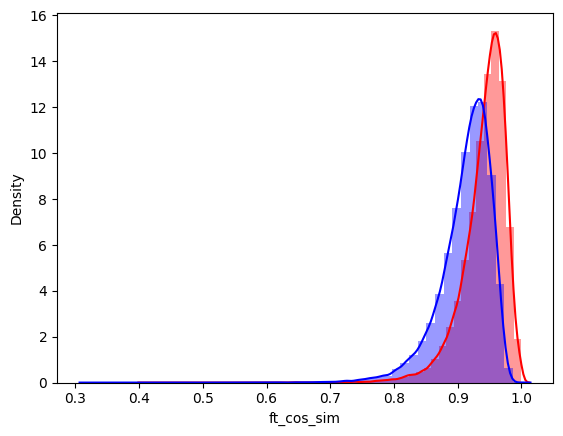

In [22]:
sns.distplot(sof_concat_df[sof_concat_df['is_duplicate'] == 1]['ft_cos_sim'][0:] , label = "1", color = 'red')
sns.distplot(sof_concat_df[sof_concat_df['is_duplicate'] == 0]['ft_cos_sim'][0:] , label = "0" , color = 'blue' )
plt.show()

d:\jupyter\big data\project\spark-test\venv_tf_1\lib\site-packages\ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.
d:\jupyter\big data\project\spark-test\venv_tf_1\lib\site-packages\ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



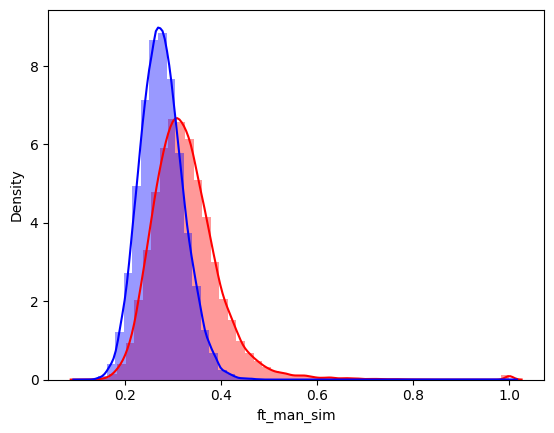

In [23]:
sns.distplot(sof_concat_df[sof_concat_df['is_duplicate'] == 1]['ft_man_sim'][0:] , label = "1", color = 'red')
sns.distplot(sof_concat_df[sof_concat_df['is_duplicate'] == 0]['ft_man_sim'][0:] , label = "0" , color = 'blue' )
plt.show()

d:\jupyter\big data\project\spark-test\venv_tf_1\lib\site-packages\ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.
d:\jupyter\big data\project\spark-test\venv_tf_1\lib\site-packages\ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



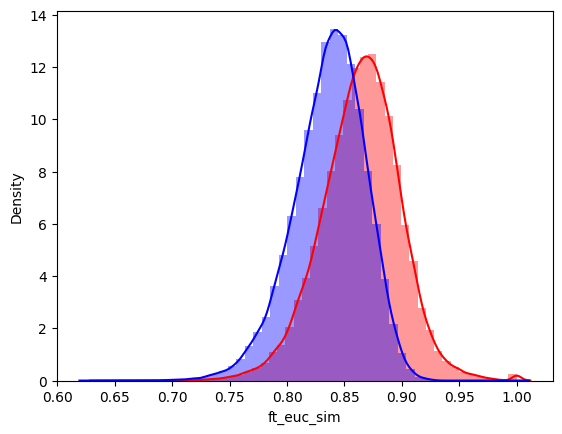

In [24]:
sns.distplot(sof_concat_df[sof_concat_df['is_duplicate'] == 1]['ft_euc_sim'][0:] , label = "1", color = 'red')
sns.distplot(sof_concat_df[sof_concat_df['is_duplicate'] == 0]['ft_euc_sim'][0:] , label = "0" , color = 'blue' )
plt.show()

# USE

In [26]:
import tensorflow_hub as hub
embed = hub.load("D:/jupyter/big data/project/spark-test/use")

In [27]:
def gen_use_embedding(text):
    embeddings = embed([text])
    return embeddings[0]

In [28]:
use_cos_sim_arr=[]
use_man_sim_arr=[]
use_euc_sim_arr=[]

for q1,q2,label in tqdm(zip(list(sof_concat_df["question1"]),list(sof_concat_df["question2"]),list(sof_concat_df["is_duplicate"]))):
    
    q1_embed = gen_use_embedding(q1.lower())
    q2_embed = gen_use_embedding(q2.lower())
    
    use_cos_sim,use_man_sim,use_euc_sim = cal_similarities(q1_embed,q2_embed)
    
    use_cos_sim_arr.append(use_cos_sim)
    use_man_sim_arr.append(use_man_sim)
    use_euc_sim_arr.append(use_euc_sim)
    
sof_concat_df["use_cos_sim"] = use_cos_sim_arr
sof_concat_df["use_man_sim"] = use_man_sim_arr
sof_concat_df["use_euc_sim"] = use_euc_sim_arr


                

100000it [06:49, 244.25it/s]


In [29]:
sof_concat_df

,question1,question2,is_duplicate,question1_cleaned,question2_cleaned,sb_cos_sim,sb_man_sim,sb_euc_sim,use_cos_sim,use_man_sim,use_euc_sim
0,standalone parentheses in javascript,A Javascript function,1,"[standalone, parenthesis, javascript]","[javascript, function]",0.848738,0.049302,0.974596,0.565140,0.056495,0.517441
1,See if a Radio button is checked that isn't in...,How to get VALUE from FORM without Submitting it?,1,"[see, radio, button, check, be, not, inside, f...","[how, get, value, form, without, submit]",0.338827,0.024686,0.516216,0.492656,0.053085,0.498177
2,Pagination and .htaccess,J2ME/Blackberry - how to read/write text file?,0,"[pagination, htaccess]","[j2meblackberry, how, readwrite, text, file]",0.371934,0.024778,0.518206,0.109520,0.039940,0.428352
3,A Windows equivalent of the Unix tail command,How will you categorise the various software t...,0,"[window, equivalent, unix, tail, command]","[how, categorise, various, software, testing, ...",0.538113,0.028768,0.590299,0.064168,0.037872,0.422282
4,Solr 4.1 Core Initialization Failure,Solr RequestHandler init failure,1,"[solr, 41, core, initialization, failure]","[solr, requesthandler, init, failure]",0.791258,0.042740,0.872217,0.790833,0.082210,0.607243
...,...,...,...,...,...,...,...,...,...,...,...
99995,PHP Maths Equation Function,"SGEN, InternalsVisibleTo and assembly signing",0,"[php, maths, equation, function]","[sgen, internalsvisibleto, assembly, signing]",0.588093,0.030861,0.635260,-0.054984,0.035581,0.407735
99996,How can I check if all the elements of an Arra...,Java all determine elements are same in a list,1,"[how, check, element, arraylist, java]","[java, determine, element, list]",0.796350,0.043191,0.874272,0.770271,0.080059,0.596007
99997,Is there a way to import a 3D model into Android?,General way to reset a member variable to its ...,0,"[way, import, 3d, model, android]","[general, way, reset, member, variable, origin...",0.366446,0.024452,0.515358,0.046242,0.037493,0.419969
99998,How to remove a wpf element on a canvas by it'...,Sign in form and register form,0,"[how, remove, wpf, element, canvas, tag, name]","[sign, form, register, form]",0.478150,0.027039,0.567456,-0.039541,0.036161,0.409517


d:\jupyter\big data\project\spark-test\venv_tf_1\lib\site-packages\ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.
d:\jupyter\big data\project\spark-test\venv_tf_1\lib\site-packages\ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



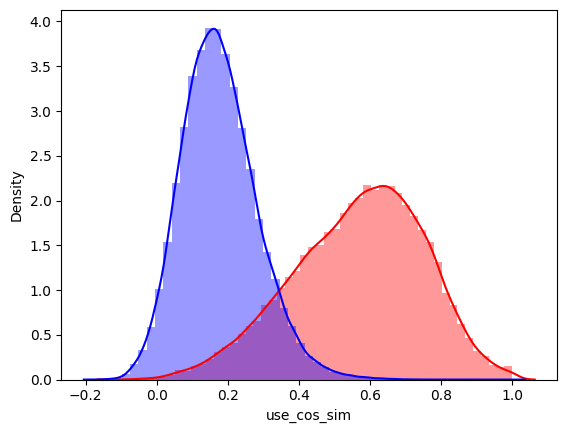

In [30]:
sns.distplot(sof_concat_df[sof_concat_df['is_duplicate'] == 1]['use_cos_sim'][0:] , label = "1", color = 'red')
sns.distplot(sof_concat_df[sof_concat_df['is_duplicate'] == 0]['use_cos_sim'][0:] , label = "0" , color = 'blue' )
plt.show()

d:\jupyter\big data\project\spark-test\venv_tf_1\lib\site-packages\ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.
d:\jupyter\big data\project\spark-test\venv_tf_1\lib\site-packages\ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



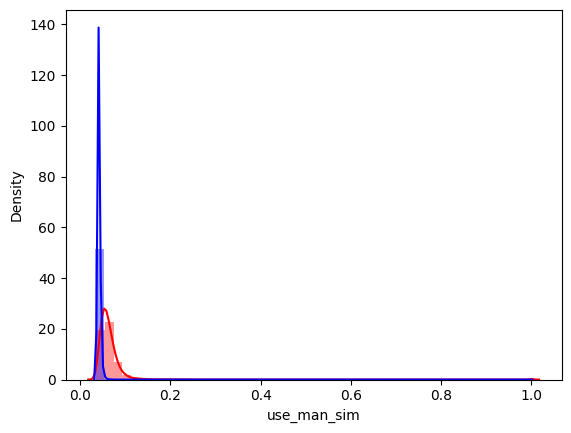

In [31]:
sns.distplot(sof_concat_df[sof_concat_df['is_duplicate'] == 1]['use_man_sim'][0:] , label = "1", color = 'red')
sns.distplot(sof_concat_df[sof_concat_df['is_duplicate'] == 0]['use_man_sim'][0:] , label = "0" , color = 'blue' )
plt.show()

d:\jupyter\big data\project\spark-test\venv_tf_1\lib\site-packages\ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.
d:\jupyter\big data\project\spark-test\venv_tf_1\lib\site-packages\ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



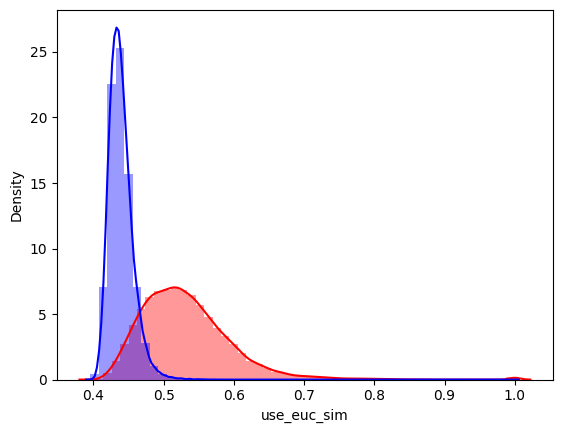

In [32]:
sns.distplot(sof_concat_df[sof_concat_df['is_duplicate'] == 1]['use_euc_sim'][0:] , label = "1", color = 'red')
sns.distplot(sof_concat_df[sof_concat_df['is_duplicate'] == 0]['use_euc_sim'][0:] , label = "0" , color = 'blue' )
plt.show()

# Feature Engineering

Number of common tokens to total word count
sorted string fuzzy ratio

In [25]:
from fuzzywuzzy import fuzz

d:\jupyter\big data\project\spark-test\venv_tf_1\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [26]:
def lower_list(tokens):
    return [t.lower() for t in tokens]

In [35]:
import string

In [27]:
alphanum_dict = dict(zip(string.ascii_lowercase+string.digits, [0]*36))

In [28]:
def compare_character_count(q1,q2):
    alphanum_dict_q1 = dict(zip(string.ascii_lowercase+string.digits, [0]*36))
    alphanum_dict_q2 = dict(zip(string.ascii_lowercase+string.digits, [0]*36))
    for l in q1:
        if l in alphanum_dict_q1:
            alphanum_dict_q1[l]+=1
            
    for l in q2:
        if l in alphanum_dict_q2:
            alphanum_dict_q2[l]+=1
    
    ratio_sum = 0
    for c in string.ascii_lowercase+string.digits:
        if alphanum_dict_q1[c]>0 and alphanum_dict_q2[c]>0:
            if len(q1)<=len(q2):
                ratio_sum = ratio_sum + (alphanum_dict_q1[c]/alphanum_dict_q2[c])
            else:
                ratio_sum = ratio_sum + (alphanum_dict_q2[c]/alphanum_dict_q1[c])
                
    return ratio_sum/36

In [29]:
def gen_char_ratio(q1,q2):
    return len((set(q1)&set(q2)))/len((set(q1)|set(q2)))

In [30]:
common_word_count_ratio = []
sorted_fuzzy_ratio = []
abs_len_diff = []
char_ratio_sum = []
char_iou = []
for q1_tokens,q2_tokens in tqdm(zip(list(sof_concat_df["question1_cleaned"]),list(sof_concat_df["question2_cleaned"]))):
    q1_tokens = lower_list(q1_tokens)
    q2_tokens = lower_list(q2_tokens)
    
    tot_count = len(q1_tokens) + len(q2_tokens)
    common_count = (len(set(q1_tokens).intersection(set(q2_tokens))))
    common_word_count_ratio.append(common_count/tot_count)
    
    sorted_q1 = ' '.join(sorted(q1_tokens))
    sorted_q2 = ' '.join(sorted(q2_tokens))
    
    abs_len_diff.append(abs(len(sorted_q1) - len(sorted_q2)))
    sorted_fuzzy_ratio.append(fuzz.ratio(sorted_q1,sorted_q2))
    char_ratio_sum.append(compare_character_count(sorted_q1,sorted_q2))
    char_iou.append(gen_char_ratio(sorted_q1,sorted_q2))

sof_concat_df["common_word_count_ratio"] = common_word_count_ratio
sof_concat_df["sorted_fuzzy_ratio"] = sorted_fuzzy_ratio
sof_concat_df["abs_len_diff"] = abs_len_diff
sof_concat_df["char_ratio_sum"] = char_ratio_sum
sof_concat_df["char_iou"] = char_iou


100000it [00:13, 7419.25it/s]


d:\jupyter\big data\project\spark-test\venv_tf_1\lib\site-packages\ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.
d:\jupyter\big data\project\spark-test\venv_tf_1\lib\site-packages\ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



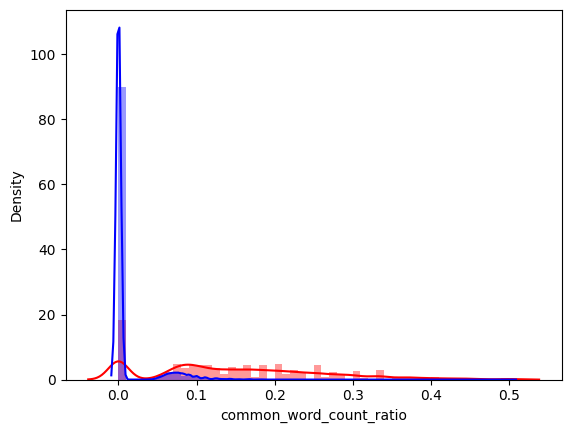

In [38]:
sns.distplot(sof_concat_df[sof_concat_df['is_duplicate'] == 1]['common_word_count_ratio'][0:] , label = "1", color = 'red')
sns.distplot(sof_concat_df[sof_concat_df['is_duplicate'] == 0]['common_word_count_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

d:\jupyter\big data\project\spark-test\venv_tf_1\lib\site-packages\ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.
d:\jupyter\big data\project\spark-test\venv_tf_1\lib\site-packages\ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



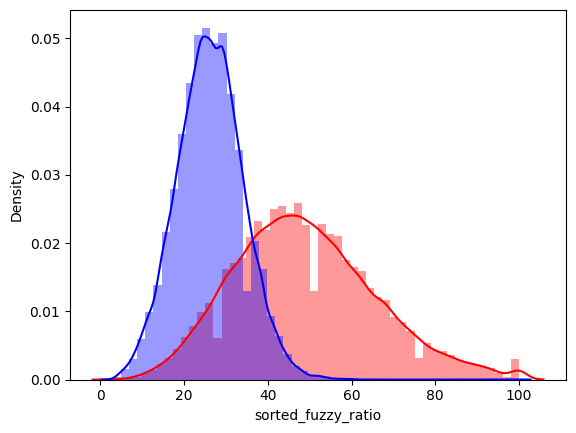

In [39]:
sns.distplot(sof_concat_df[sof_concat_df['is_duplicate'] == 1]['sorted_fuzzy_ratio'][0:] , label = "1", color = 'red')
sns.distplot(sof_concat_df[sof_concat_df['is_duplicate'] == 0]['sorted_fuzzy_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

d:\jupyter\big data\project\spark-test\venv_tf_1\lib\site-packages\ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.
d:\jupyter\big data\project\spark-test\venv_tf_1\lib\site-packages\ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



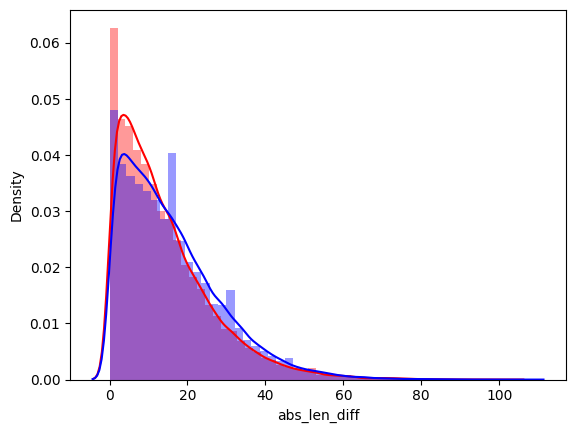

In [31]:
sns.distplot(sof_concat_df[sof_concat_df['is_duplicate'] == 1]['abs_len_diff'][0:] , label = "1", color = 'red')
sns.distplot(sof_concat_df[sof_concat_df['is_duplicate'] == 0]['abs_len_diff'][0:] , label = "0" , color = 'blue' )
plt.show()

d:\jupyter\big data\project\spark-test\venv_tf_1\lib\site-packages\ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.
d:\jupyter\big data\project\spark-test\venv_tf_1\lib\site-packages\ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



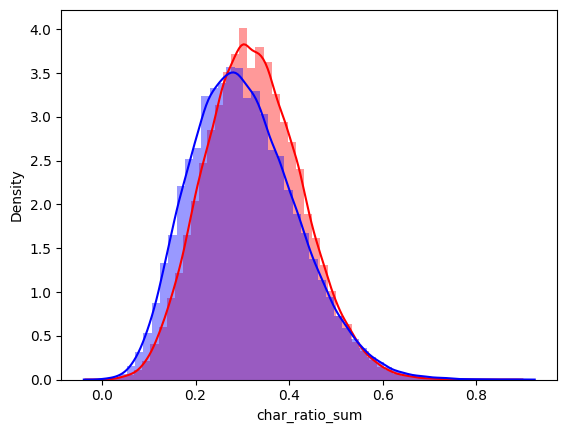

In [32]:
sns.distplot(sof_concat_df[sof_concat_df['is_duplicate'] == 1]['char_ratio_sum'][0:] , label = "1", color = 'red')
sns.distplot(sof_concat_df[sof_concat_df['is_duplicate'] == 0]['char_ratio_sum'][0:] , label = "0" , color = 'blue' )
plt.show()

d:\jupyter\big data\project\spark-test\venv_tf_1\lib\site-packages\ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.
d:\jupyter\big data\project\spark-test\venv_tf_1\lib\site-packages\ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



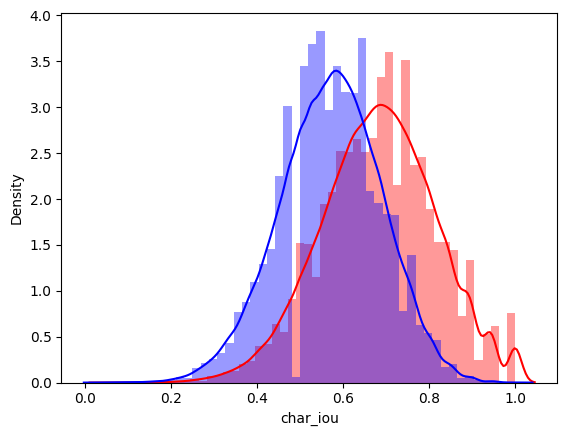

In [33]:
sns.distplot(sof_concat_df[sof_concat_df['is_duplicate'] == 1]['char_iou'][0:] , label = "1", color = 'red')
sns.distplot(sof_concat_df[sof_concat_df['is_duplicate'] == 0]['char_iou'][0:] , label = "0" , color = 'blue' )
plt.show()

In [109]:
sof_concat_df

,question1,question2,is_duplicate,question1_cleaned,question2_cleaned,sb_cos_sim,sb_man_sim,sb_euc_sim,use_cos_sim,use_man_sim,use_euc_sim,common_word_count_ratio,sorted_fuzzy_ratio
0,How To Properly Create Domain using Zend Frame...,Add records from external ruby script,0,"[how, properly, create, domain, use, zend, fra...","[add, record, external, ruby, script]",0.450274,0.026406,0.548539,0.348263,0.046645,0.466919,0.000000,8
1,strange Fatal error: Cannot redeclare class pa...,PHP Fatal error: Cannot redeclare class,1,"[strange, fatal, error, can, not, redeclare, c...","[php, fatal, error, can, not, redeclare, class]",0.764689,0.041130,0.833274,0.750127,0.074904,0.585848,0.200000,82
2,Fuzzy substring search in O(N log N),Fastest way to find minimal Hamming distance t...,1,"[fuzzy, substring, search, log, n]","[fast, way, find, minimal, hamming, distance, ...",0.483319,0.027673,0.579418,0.582151,0.057934,0.522421,0.041667,42
3,How to install CodeRush Xpress on VS2005,How do I find out how much free memory is left...,0,"[how, install, coderush, xpress, vs2005]","[how, find, how, much, free, memory, leave, gn...",0.548876,0.030009,0.625877,0.350268,0.046742,0.467303,0.033333,32
4,Add tooltip programmatically on asp.net web page,tooltips for Button,1,"[add, tooltip, programmatically, aspnet, web, ...","[tooltip, button]",0.655901,0.033523,0.687599,0.485400,0.053052,0.496402,0.062500,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,"Tools, Visual Studio Setting to check uninitia...",detect current tab,0,"[tool, visual, studio, set, check, uninitializ...","[detect, current, tab]",0.431152,0.025803,0.537416,0.203009,0.041528,0.441983,0.000000,19
1996,How do I parse a string to a float or int?,"In .aspx, how to pass a value from asp:Repeate...",0,"[how, parse, string, float, int]","[aspx, how, pass, value, asprepeater, code, be...",0.682714,0.035912,0.746682,0.431513,0.049283,0.483959,0.038462,28
1997,ASP.NET MVC and Paging - Search & Result Scenario,"SSIS package works with windows account, fails...",0,"[aspnet, mvc, page, search, result, scenario]","[ssis, package, work, windows, account, fail, ...",0.440151,0.027059,0.570081,0.126714,0.040168,0.430741,0.000000,39
1998,"Create an ""all-in-one"" function using DS in C#",Header page in PHP that takes the application ...,0,"[create, allinone, function, use, ds, c]","[header, page, php, take, application, directo...",0.665956,0.034621,0.700457,0.157098,0.041489,0.435088,0.000000,27


# Normalize and split

In [43]:
from sklearn.preprocessing import MinMaxScaler


In [40]:
sof_data = sof_concat_df.drop(columns=['question1', 'question2','question1_cleaned','question2_cleaned',"sb_man_sim","use_man_sim","sb_euc_sim","use_man_sim"])

In [15]:
#sof_data.to_pickle("./sof_data.pkl")
sof_data = pd.read_pickle("./sof_data.pkl") 

In [43]:
# sb_euc_scaler = MinMaxScaler().fit(np.array(sof_concat_df["sb_euc_sim"]).reshape(-1,1))
# use_euc_scaler = MinMaxScaler().fit(np.array(sof_concat_df["use_euc_sim"]).reshape(-1,1))
fuzzy_scaler = MinMaxScaler().fit(np.array(sof_data["sorted_fuzzy_ratio"]).reshape(-1,1))
wr_scaler = MinMaxScaler().fit(np.array(sof_data["common_word_count_ratio"]).reshape(-1,1))

In [17]:
#sof_data["sb_man_sim"] = MinMaxScaler().fit_transform(np.array(sof_data["sb_man_sim"]).reshape(-1,1))
#sof_data["sb_euc_sim"] = MinMaxScaler().fit_transform(np.array(sof_data["sb_euc_sim"]).reshape(-1,1))
sof_data["sorted_fuzzy_ratio"] = fuzzy_scaler.transform(np.array(sof_data["sorted_fuzzy_ratio"]).reshape(-1,1))
#sof_data["use_man_sim"] = MinMaxScaler().fit_transform(np.array(sof_data["sb_man_sim"]).reshape(-1,1))
sof_data["common_word_count_ratio"] = wr_scaler.transform(np.array(sof_data["common_word_count_ratio"]).reshape(-1,1))


In [18]:
sof_data

,is_duplicate,sb_cos_sim,use_cos_sim,use_euc_sim,common_word_count_ratio,sorted_fuzzy_ratio
0,1,0.848738,0.565140,0.517441,0.400000,0.360825
1,1,0.338827,0.492656,0.498177,0.125000,0.216495
2,0,0.371934,0.109520,0.428352,0.000000,0.257732
3,0,0.538113,0.064168,0.422282,0.000000,0.247423
4,1,0.791258,0.790833,0.607243,0.444444,0.556701
...,...,...,...,...,...,...
99995,0,0.588093,-0.054984,0.407735,0.000000,0.247423
99996,1,0.796350,0.770271,0.596007,0.444444,0.525773
99997,0,0.366446,0.046242,0.419969,0.142857,0.288660
99998,0,0.478150,-0.039541,0.409517,0.000000,0.237113


In [47]:
import pickle

In [46]:
# pickle.dump(sb_euc_scaler, open("sb_euc_scaler.sav", 'wb'))
# pickle.dump(use_euc_scaler, open("use_euc_scaler.sav", 'wb'))
pickle.dump(fuzzy_scaler, open("fuzzy_scaler.sav", 'wb'))
pickle.dump(wr_scaler, open("wr_scaler.sav", 'wb'))

In [19]:
x_data = sof_data.iloc[:,1:]
y_data = sof_data.iloc[:,0]

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x_data, y_data, test_size=0.33, random_state=42)

In [21]:
Y_test.value_counts()

1    16526
0    16474
Name: is_duplicate, dtype: int64

# PCA

In [52]:
from __future__ import print_function
import time

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

In [53]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
principalComponents = pca.fit_transform(x_data)

In [54]:
PCADF = pd.DataFrame(data = principalComponents, columns = ['component 1'])

In [55]:
finalPCADF = pd.concat([PCADF, y_data],axis = 1)

In [57]:
s=finalPCADF.loc[finalPCADF["is_duplicate"]==1]["component 1"].shape

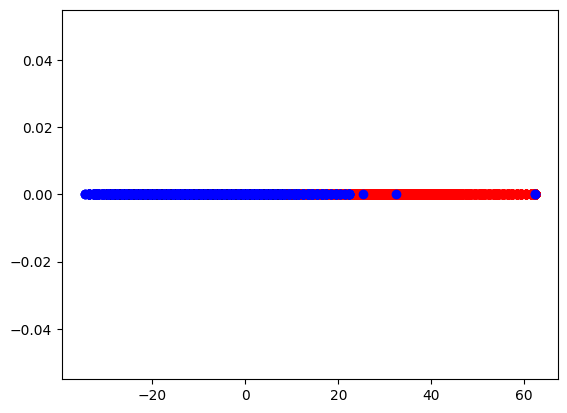

In [58]:
plt.scatter(finalPCADF.loc[finalPCADF["is_duplicate"]==1]["component 1"],np.zeros(s), c = "red")
plt.scatter(finalPCADF.loc[finalPCADF["is_duplicate"]==0]["component 1"],np.zeros(s), c = "blue")
plt.show()

# Model

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV

In [154]:
params = {'max_depth': [2,3,4,5],
          'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
          'subsample': np.arange(0.5, 1.0, 0.1),
          'colsample_bytree': np.arange(0.5, 1.0, 0.1),
          'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
          'n_estimators': [100, 250, 500, 750],
          }

xgbclf = XGBClassifier(objective="binary:logistic")
clf = RandomizedSearchCV(estimator=xgbclf,
                         param_distributions=params,
                         scoring='accuracy',
                         n_iter=25,
                         n_jobs=3,
                         verbose=1)

clf.fit(X_train, Y_train)

best_combination = clf.best_params_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


In [155]:
best_combination

{'subsample': 0.8999999999999999,
 'n_estimators': 750,
 'max_depth': 2,
 'learning_rate': 0.01,
 'colsample_bytree': 0.7999999999999999,
 'colsample_bylevel': 0.5}

In [164]:
model = XGBClassifier(objective="binary:logistic",subsample=0.7,n_estimators=750,max_depth=4,learning_rate=0.01,colsample_bytree = 0.6,colsample_bylevel=0.79)

In [165]:
model.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.79, colsample_bynode=1, colsample_bytree=0.6,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=750,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

# Neural network

In [31]:
x_traindata = X_train.to_numpy(dtype="float32")
y_traindata = Y_train.to_numpy(dtype="float32")

In [27]:
x_testdata = X_test.to_numpy(dtype="float32")
y_testdata = Y_test.to_numpy(dtype="float32")

In [29]:
from torch.utils.data import Dataset, DataLoader
class dataset(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.length = self.x.shape[0]
 
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
    def __len__(self):
        return self.length

In [32]:
trainset = dataset(x_traindata,y_traindata)
trainloader = DataLoader(trainset,batch_size=1000,shuffle=False)

testset = dataset(x_testdata,y_testdata)
testloader = DataLoader(testset,batch_size=len(testset),shuffle=False)

In [54]:
from torch import nn
from torch.nn import functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.layer1 = nn.Linear(5,3)
        self.layer2 = nn.Linear(3,1)
    def forward(self,x):
        x = torch.relu(self.layer1(x))
        x = torch.sigmoid(self.layer2(x))
        return x

In [35]:
def calc_acc(pred,y_data):
    match_arr=[]
    for p,y in (zip(pred,y_data)):
        if p==y:
            match_arr.append(1)
        else:
            match_arr.append(0)
    return np.mean(match_arr)

In [56]:
epochs = 50
model = Net()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
loss_fn = nn.BCELoss()

In [57]:
def pass_threshold(pred):
    ret_pred = []
    for p in pred:
        if p>0.7:
            ret_pred.append(1)
        else:
            ret_pred.append(0)
    return ret_pred
    

In [58]:
losses = []
test_acc_arr = []
train_acc_arr = []
for i in range(epochs):
    for x_train,y_train in trainloader:
        output = model(x_train)

        loss = loss_fn(output,y_train.reshape(-1,1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.detach().numpy())
    
    train_predicted = model(torch.tensor(x_traindata,dtype=torch.float32))
    train_pred = pass_threshold(train_predicted.reshape(-1).detach().numpy())
#     test_predicted = model(torch.tensor(data,dtype=torch.float32))
#     test_pred = pass_threshold(test_predicted.reshape(-1).detach().numpy())

    train_acc=calc_acc(train_pred,y_traindata)
    train_acc_arr.append(train_acc)
    
    tx,ty = next(iter(testloader))
    test_predicted = model(torch.tensor(tx,dtype=torch.float32))
    test_pred = pass_threshold(test_predicted.reshape(-1).detach().numpy())
    test_acc=calc_acc(test_pred,ty)
    test_acc_arr.append(test_acc)
    
    print("epoch {}\tTrain Accuracy : {}".format(i,train_acc))
    print("epoch {}\tTest Accuracy : {}".format(i,test_acc))

d:\jupyter\big data\project\spark-test\venv_tf_1\lib\site-packages\ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch 0	Train Accuracy : 0.5003880597014926
epoch 0	Test Accuracy : 0.4992121212121212
epoch 1	Train Accuracy : 0.5003880597014926
epoch 1	Test Accuracy : 0.4992121212121212
epoch 2	Train Accuracy : 0.5003880597014926
epoch 2	Test Accuracy : 0.4992121212121212
epoch 3	Train Accuracy : 0.5003880597014926
epoch 3	Test Accuracy : 0.4992121212121212
epoch 4	Train Accuracy : 0.5067611940298508
epoch 4	Test Accuracy : 0.5054545454545455
epoch 5	Train Accuracy : 0.5312686567164179
epoch 5	Test Accuracy : 0.5286060606060606
epoch 6	Train Accuracy : 0.580134328358209
epoch 6	Test Accuracy : 0.5757272727272728
epoch 7	Train Accuracy : 0.636955223880597
epoch 7	Test Accuracy : 0.6325454545454545
epoch 8	Train Accuracy : 0.6872388059701493
epoch 8	Test Accuracy : 0.6818484848484848
epoch 9	Train Accuracy : 0.727044776119403
epoch 9	Test Accuracy : 0.7215151515151516
epoch 10	Train Accuracy : 0.755955223880597
epoch 10	Test Accuracy : 0.7536969696969696
epoch 11	Train Accuracy : 0.7783880597014925


Text(0, 0.5, 'loss')

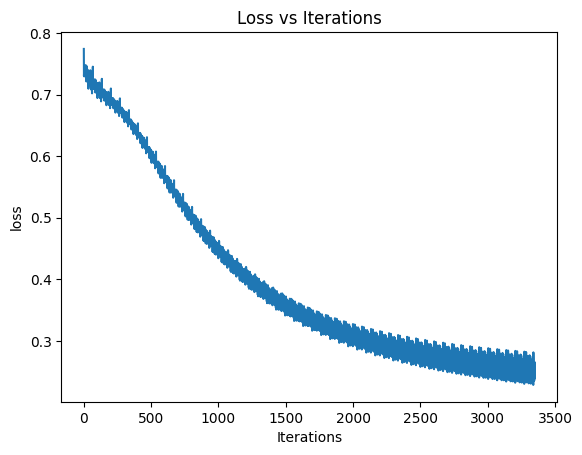

In [59]:
plt.plot(losses)
plt.title('Loss vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('loss')

Text(0, 0.5, 'Train Accuracy')

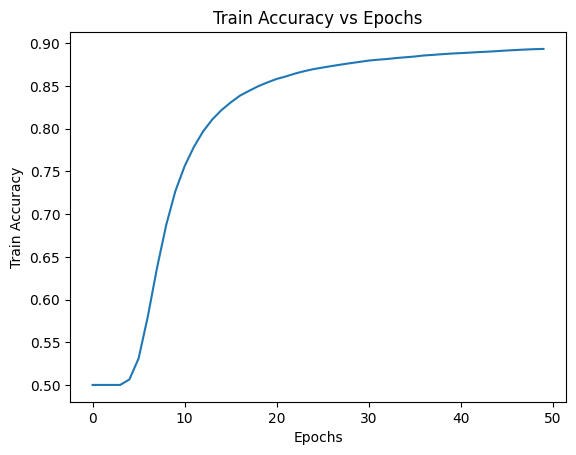

In [60]:
plt.plot(train_acc_arr)
plt.title('Train Accuracy vs Epochs')
plt.xlabel('Epochs')

plt.ylabel('Train Accuracy')

Text(0, 0.5, 'Test Accuracy')

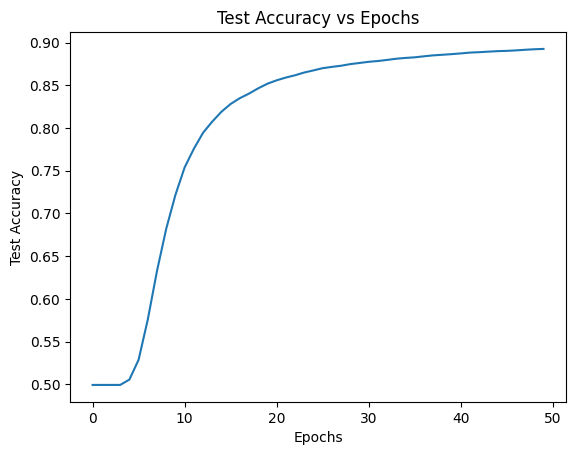

In [61]:
plt.plot(test_acc_arr)
plt.title('Test Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')

In [84]:
torch.save(model, "mlp_model")

# Testing

In [45]:
tx,ty = next(iter(testloader))
test_predicted = model_2(torch.tensor(tx,dtype=torch.float32))
test_pred = pass_threshold(test_predicted.reshape(-1).detach().numpy())

d:\jupyter\big data\project\spark-test\venv_tf_1\lib\site-packages\ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [46]:
calc_acc(test_pred,Y_test)

0.8975151515151515

In [169]:
model.save_model("model.txt")
# model = xgb.Booster()
# model.load_model("model.txt")

<AxesSubplot:>

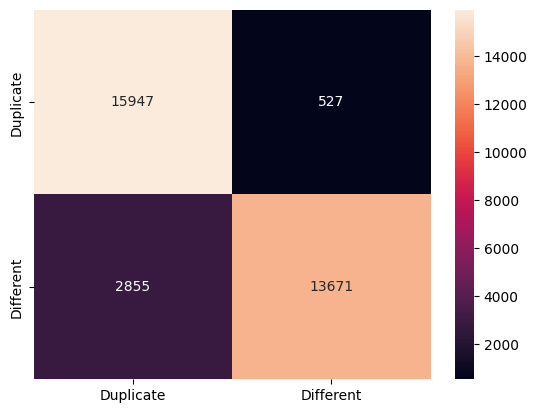

In [56]:
from sklearn.metrics import confusion_matrix
import seaborn as sb
labels = ["Duplicate","Different"]
confusion_matrix = confusion_matrix(Y_test,test_pred)
df_cm = pd.DataFrame(confusion_matrix, index = [i for i in labels],columns = [i for i in labels])
sb.heatmap(df_cm, annot=True,fmt='g')

# Inference

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import spacy
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import spacy
import glob
import os
import re
import string
from bs4 import BeautifulSoup
import nltk
from sentence_transformers import SentenceTransformer
import tensorflow_hub as hub
from fuzzywuzzy import fuzz
from sklearn.preprocessing import MinMaxScaler

d:\jupyter\big data\project\spark-test\venv_tf_1\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\jupyter\big data\project\spark-test\venv_tf_1\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
from scipy.spatial.distance import cosine,cityblock,euclidean,minkowski,jaccard

In [3]:
import pickle

In [4]:
nltk.download('stopwords')
embed = hub.load("D:/jupyter/big data/project/spark-test/use")
sbert_model = SentenceTransformer("D:\\jupyter\\big data\\project\\model\\distilbert-base-nli-mean-tokens")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\reddy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
def preprocess(question):
    stop_words = nltk.corpus.stopwords.words("english")
    question = re.sub(r'\n', '', question)
    remove_punct = str.maketrans('', '', string.punctuation)
    question = question.translate(remove_punct)
    question = question.split()
    question = [word for word in question if not word in stop_words]
    question = nlp(' '.join(question))
    lemma_words = [y.lemma_ for y in question]
    return lemma_words

In [6]:
def cal_similarities(q1_embed,q2_embed):
    cos_sim = 1-cosine(q1_embed,q2_embed)
    man_sim = cityblock(q1_embed,q2_embed)
    euc_sim = euclidean(q1_embed,q2_embed)
    return cos_sim,man_sim,euc_sim

In [7]:
def gen_sbert_embedding(text):
    vectors = sbert_model.encode(text)
    return vectors

In [8]:
def gen_use_embedding(text):
    embeddings = embed([text])
    return embeddings[0]

In [9]:
# sb_euc_scaler = pickle.load(open("sb_euc_scaler.sav", 'rb'))
# use_euc_scaler = pickle.load(open("use_euc_scaler.sav", 'rb'))
fuzzy_scaler = pickle.load(open("fuzzy_scaler.sav", 'rb'))
wr_scaler = pickle.load(open("wr_scaler.sav", 'rb'))

In [10]:
def pass_threshold(pred):
    ret_pred = []
    for p in pred:
        if p>0.65:
            ret_pred.append(1)
        else:
            ret_pred.append(0)
    return ret_pred
    

In [11]:
nlp = spacy.load("en_core_web_lg-3.4.1/en_core_web_lg/en_core_web_lg-3.4.1")

In [12]:
from torch import nn
from torch.nn import functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.layer1 = nn.Linear(5,3)
        self.layer2 = nn.Linear(3,1)
    def forward(self,x):
        x = torch.relu(self.layer1(x))
        x = torch.sigmoid(self.layer2(x))
        return x

In [13]:
model = Net()

In [14]:
model_2 = torch.load("mlp_model")

In [15]:
torch.save(model_2.state_dict(), "mlp_model")


In [16]:
the_model = Net()
the_model.load_state_dict(torch.load("mlp_model"))

<All keys matched successfully>

In [17]:
def is_similar(q1,q2):
    q1 = q1.lower()
    q2 = q2.lower()
    q1_proc_words = preprocess(q1)
    q2_proc_words = preprocess(q2)
    print(q1_proc_words)
    print(q2_proc_words)
    
    q1_sb_embed = gen_sbert_embedding(q1)
    q2_sb_embed = gen_sbert_embedding(q2)
    sb_cos_sim,sb_man_sim,sb_euc_sim = cal_similarities(q1_sb_embed,q2_sb_embed)
#     sb_euc_sim = sb_euc_scaler.transform(np.array([sb_euc_sim]).reshape(-1,1))[0][0]
    
    q1_use_embed = gen_use_embedding(q1)
    q2_use_embed = gen_use_embedding(q2)
    use_cos_sim,use_man_sim,use_euc_sim = cal_similarities(q1_use_embed,q2_use_embed)
#     use_euc_sim = use_euc_scaler.transform(np.array([use_euc_sim]).reshape(-1,1))[0][0]
    
    tot_count = len(q1_proc_words) + len(q2_proc_words)
    common_count = (len(set(q1_proc_words).intersection(set(q2_proc_words))))
    common_word_count_ratio = common_count/tot_count
    common_word_count_ratio = wr_scaler.transform(np.array([common_word_count_ratio/5]).reshape(-1,1))[0][0]

    sorted_q1 = ' '.join(sorted(q1_proc_words))
    sorted_q2 = ' '.join(sorted(q2_proc_words))
    sorted_fuzzy_ratio = fuzz.ratio(sorted_q1,sorted_q2)
    sorted_fuzzy_ratio = fuzzy_scaler.transform(np.array([sorted_fuzzy_ratio/10]).reshape(-1,1))[0][0]
    
    data = pd.DataFrame([[sb_cos_sim,use_cos_sim,use_euc_sim,common_word_count_ratio,sorted_fuzzy_ratio]], columns=["sb_cos_sim","use_cos_sim","use_euc_sim","common_word_count_ratio","sorted_fuzzy_ratio"])
    data = data.to_numpy(dtype="float32")
    print(data)
    
    if len(q1)>0 and len(q2)>0 : 
        
        test_predicted = model_2(torch.tensor(data,dtype=torch.float32))
        print(test_predicted)
        test_pred = pass_threshold(test_predicted.reshape(-1).detach().numpy())
        print(test_pred)
        if test_pred[0]==1:
            print("Both questions are similar")
        else:
            print("They are different questions")
    else:
        print("Try Again with a proper sentence")


In [18]:
is_similar("how to use transformers models","how to train hugging face transformers")

['use', 'transformer', 'model']
['train', 'hug', 'face', 'transformer']
[[0.8020606  0.5998551  0.8945891  0.05714286 0.0257732 ]]
tensor([[0.6563]], grad_fn=<SigmoidBackward0>)
[1]
Both questions are similar


In [35]:
import pandas as pd

In [36]:
test_qs = [["how to use transformers models","how to train hugging face transformers"],["What is derivative of Sigmoid function","how to differentiate sigmoid"],["What is derivative of Sigmoid function","how to differentiate tanh"],["how to live a healty life","where does heath ledger live"],["how to handle exception in java","heapoverflow exception occured in java"],["how to handle exception in java","heapoverflow exception occured in python"],["How does map reduce work","explain map reduce in hadoop"],["how to store data in s3","error while storing data in postgress"]]

In [37]:
test_qs = pd.DataFrame(test_qs, columns = ['Question 1', 'Question 2'])

In [38]:
test_qs

,Question 1,Question 2
0,how to use transformers models,how to train hugging face transformers
1,What is derivative of Sigmoid function,how to differentiate sigmoid
2,What is derivative of Sigmoid function,how to differentiate tanh
3,how to live a healty life,where does heath ledger live
4,how to handle exception in java,heapoverflow exception occured in java
5,how to handle exception in java,heapoverflow exception occured in python
6,How does map reduce work,explain map reduce in hadoop
7,how to store data in s3,error while storing data in postgress


# Custom Train BERTOverflow (Future Scope)

In [405]:
from torch.utils.data import DataLoader
import math
from sentence_transformers import LoggingHandler, util
from sentence_transformers.cross_encoder import CrossEncoder
from sentence_transformers.evaluation import BinaryClassificationEvaluator
from sentence_transformers.readers import InputExample
import logging
from datetime import datetime
import os
import gzip
import csv


In [395]:
sof_concat_df

,question1,question2,is_duplicate,question1_cleaned,question2_cleaned,sb_cos_sim,sb_man_sim,sb_euc_sim,use_cos_sim,use_man_sim,use_euc_sim,common_word_count_ratio,sorted_fuzzy_ratio
0,Custom UITableViewCell with round rect,IPV6 usage study,0,"[custom, uitableviewcell, round, rect]","[ipv6, usage, study]",0.573133,0.030964,0.627948,0.035762,0.038205,0.418638,0.000000,12
1,Painless integration of Eclipse with Vim?,Unable to connect mysql from Sequel gem,0,"[painless, integration, eclipse, vim]","[unable, connect, mysql, sequel, gem]",0.550999,0.030027,0.618608,0.163138,0.041300,0.435972,0.000000,32
2,"Access custom Increment (""yy"" & 0000)",Create sequential ID value based on the year t...,1,"[access, custom, increment, yy, 0000]","[create, sequential, i, d, value, base, year, ...",0.528018,0.029551,0.593704,0.305784,0.044596,0.459070,0.000000,30
3,Open source PDF renderer for .NET?,Python parsing bracketed blocks,0,"[open, source, pdf, renderer, net]","[python, parse, bracket, block]",0.572499,0.030062,0.608731,0.092916,0.039092,0.426092,0.000000,30
4,Subset a dataframe in two dataframes by values...,"Filter by ranges supplied by two vectors, with...",1,"[subset, dataframe, two, dataframe, value, two...","[filter, range, supply, two, vector, without, ...",0.566993,0.031624,0.647182,0.392363,0.047987,0.475648,0.058824,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,How can I reference the element that contains ...,python name a file same as a lib,0,"[how, reference, element, contain, event, func...","[python, name, file, lib]",0.437883,0.026381,0.544613,0.233864,0.043188,0.446858,0.000000,12
99996,Change value of dataframe which based on in r,Replacing matrix elements indexed by another m...,1,"[change, value, dataframe, which, base, r]","[replace, matrix, element, index, another, mat...",0.730463,0.037454,0.770306,0.410017,0.049500,0.479326,0.000000,33
99997,Deterministic handle allocation algorithm,Formatting doubles for output in C#,0,"[deterministic, handle, allocation, algorithm]","[formatting, double, output, c]",0.603851,0.031812,0.651306,0.194946,0.041751,0.440742,0.000000,30
99998,Your thoughts on web design for 16:9 screens,Will Garbage Collected C be Faster Than C++?,0,"[thought, web, design, 169, screen]","[garbage, collect, c, fast, c]",0.364814,0.025420,0.532797,0.049885,0.038451,0.420435,0.000000,23


In [396]:
from sklearn.model_selection import train_test_split
train_qs, test_qs = train_test_split(sof_concat_df, test_size=0.2, random_state=42)

In [399]:
train_samples = []
for q1,q2,label in tqdm(zip(list(train_qs["question1"]),list(train_qs["question2"]),list(train_qs["is_duplicate"]))):
    train_samples.append(InputExample(texts=[q1,q2],label=label))

80000it [00:00, 167754.97it/s]


In [400]:
test_samples = []
for q1,q2,label in tqdm(zip(list(test_qs["question1"]),list(test_qs["question2"]),list(test_qs["is_duplicate"]))):
    test_samples.append(InputExample(texts=[q1,q2], label=label))

20000it [00:00, 63047.69it/s]


In [418]:
train_batch_size = 100
num_epochs = 4

In [402]:
bert_overflow_model = CrossEncoder("jeniya/BERTOverflow", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at jeniya/BERTOverflow and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [407]:
evaluator = BinaryClassificationEvaluator.from_input_examples(test_samples)

In [419]:
train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size)

In [409]:
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1)

In [ ]:
bert_overflow_model.fit(train_dataloader=train_dataloader,epochs=num_epochs,warmup_steps=warmup_steps, output_path="bert_overflow_model")

Iteration:   0%|                                                                               | 0/800 [00:00<?, ?it/s]